In [1]:
import sys

from pathlib import Path
from datetime import timedelta
import time 
import os
import dateutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm.notebook import trange, tqdm
from TaPR_pkg import etapr
import random

In [2]:
# 사용할 GPU 설정
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" # PCI_BUS_ID 기준으로 control하겠다는 의미인듯.
os.environ["CUDA_VISIBLE_DEVICES"]="3" # [number]는 GPU 번호. (복수도 가능 ex. "1,2")
print(torch.cuda.is_available())

True


In [3]:
# seed 고정을 위한 함수 정의
def seed_everything(seed = 777):
    
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

In [4]:
seed_everything()
def dataframe_from_csv(target):
    return pd.read_csv(target).rename(columns=lambda x: x.strip())

def dataframe_from_csvs(targets):
    return pd.concat([dataframe_from_csv(x) for x in targets])

def normalize(df, min_, max_):
    ndf = df.copy()
    for c in df.columns:
        if min_[c] == max_[c]:
            ndf[c] = df[c] - min_[c]
        else:
            ndf[c] = (df[c] - min_[c]) / (max_[c] - min_[c])
    return ndf

def boundary_check(df):
    x = np.array(df, dtype=np.float32)
    return np.any(x > 1.0), np.any(x < 0), np.any(np.isnan(x))

In [5]:
seed_everything()
# 추론 하지 않을 상태변수 index (입력에는 사용)
DEL_IDX = [2, 13, 17, 18, 20, 21, 24, 32, 33, 34, 36, 42, 50, 51, 58, 60, 62, 63, 64, 64, 66]# 
IDF_IDX = [67, 77, 70, 15, 37, 47, 27]
LEAV_IDX = [i for i in range(79) if i not in DEL_IDX]

# 추론할 상태변수 index (입력, 출력 모두 사용)
DF_IDX = [i for i in LEAV_IDX if i not in IDF_IDX]

In [8]:
seed_everything()
TRAIN_DATASET = sorted([x for x in Path("./train/").glob("*.csv")])
VALIDATION_DATASET = sorted([x for x in Path("./validation/").glob("*.csv")])
TEST_DATASET = sorted([x for x in Path("./test/").glob("*.csv")])

In [9]:
seed_everything()
TRAIN_DF_RAW = dataframe_from_csvs(TRAIN_DATASET)
TRAIN_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-11 10:00:00,-2.2642,0,12.26196,-0.00087,12.01019,0.2254,12.66931,70,1,...,0.92255,30.08042,7.08818,595.06104,276.40338,1,1014.79321,12.0,50,3506
1,2021-07-11 10:00:01,-2.4923,0,12.26196,0.00058,12.56714,-0.0711,12.66931,70,1,...,0.92255,30.08423,7.08818,531.50317,276.18634,1,1014.79321,12.0,50,3493
2,2021-07-11 10:00:02,-2.8460,0,12.26196,-0.00072,14.48975,0.0051,12.66931,70,1,...,0.91873,30.09148,7.08818,451.06253,279.85754,1,1014.79321,12.0,50,3490
3,2021-07-11 10:00:03,-2.1235,0,12.26196,0.00101,15.93170,0.1842,12.66931,70,1,...,0.91644,30.10407,7.08818,404.38739,281.50317,1,1014.79321,12.0,50,3525
4,2021-07-11 10:00:04,-2.9074,0,12.26196,0.00043,16.10718,0.1842,12.66931,70,1,...,0.91797,30.10331,7.08818,382.53925,281.34039,1,1014.79321,12.0,50,3503
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259195,2021-08-09 08:59:56,-2.0065,0,12.26196,0.00051,100.28228,0.5977,12.53358,70,1,...,1.17355,35.05434,10.00000,3178.48877,370.02679,1,986.05908,12.0,50,136
259196,2021-08-09 08:59:57,-2.2101,0,12.26196,-0.00029,100.28228,0.5509,12.53358,70,1,...,1.16898,35.03488,10.00000,3175.36084,370.40656,1,986.05908,12.0,50,89
259197,2021-08-09 08:59:58,-2.3325,0,12.26196,0.00152,100.28228,0.5425,12.53358,70,1,...,1.16974,35.02840,10.00000,3175.73608,368.12787,1,986.05908,12.0,50,90
259198,2021-08-09 08:59:59,-2.3049,0,12.26196,0.00058,100.26703,0.6266,12.53358,70,1,...,1.16974,35.02420,10.00000,3176.61182,368.01941,1,986.05908,12.0,50,74


In [12]:
seed_everything()
TIMESTAMP_FIELD = "timestamp"
IDSTAMP_FIELD = 'id'
ATTACK_FIELD = "attack"
VALID_COLUMNS_IN_TRAIN_DATASET = TRAIN_DF_RAW.columns.drop([TIMESTAMP_FIELD])
VALID_COLUMNS_IN_TRAIN_DATASET

Index(['C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10',
       'C11', 'C12', 'C13', 'C14', 'C15', 'C16', 'C17', 'C18', 'C19', 'C20',
       'C21', 'C22', 'C23', 'C24', 'C25', 'C26', 'C27', 'C28', 'C29', 'C30',
       'C31', 'C32', 'C33', 'C34', 'C35', 'C36', 'C37', 'C38', 'C39', 'C40',
       'C41', 'C42', 'C43', 'C44', 'C45', 'C46', 'C47', 'C48', 'C49', 'C50',
       'C51', 'C52', 'C53', 'C54', 'C55', 'C56', 'C57', 'C58', 'C59', 'C60',
       'C61', 'C62', 'C63', 'C64', 'C65', 'C66', 'C67', 'C68', 'C69', 'C70',
       'C71', 'C72', 'C73', 'C74', 'C75', 'C76', 'C77', 'C78', 'C79', 'C80',
       'C81', 'C82', 'C83', 'C84', 'C85', 'C86'],
      dtype='object')

In [13]:
seed_everything()
TAG_MIN = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].min()
TAG_MAX = TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET].max()
TRAIN_DF = normalize(TRAIN_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET], TAG_MIN, TAG_MAX)#.ewm(span=90).mean()
TRAIN_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,0.433107,0.0,0.056338,0.501686,0.116706,0.447955,0.816071,0.0,0.0,0.0,...,0.240561,0.194185,0.708818,0.183693,0.169066,0.0,0.538147,0.0,0.0,0.276078
1,0.391297,0.0,0.056338,0.519147,0.122242,0.391963,0.816071,0.0,0.0,0.0,...,0.240561,0.194570,0.708818,0.163699,0.168259,0.0,0.538147,0.0,0.0,0.275086
2,0.326466,0.0,0.056338,0.503492,0.141351,0.406353,0.816071,0.0,0.0,0.0,...,0.238072,0.195302,0.708818,0.138395,0.181916,0.0,0.538147,0.0,0.0,0.274857
3,0.458896,0.0,0.056338,0.524326,0.155684,0.440174,0.816071,0.0,0.0,0.0,...,0.236580,0.196575,0.708818,0.123712,0.188038,0.0,0.538147,0.0,0.0,0.277528
4,0.315212,0.0,0.056338,0.517341,0.157428,0.440174,0.816071,0.0,0.0,0.0,...,0.237577,0.196498,0.708818,0.116839,0.187433,0.0,0.538147,0.0,0.0,0.275849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
259195,0.480342,0.0,0.056338,0.518304,0.994085,0.518261,0.640361,0.0,0.0,0.0,...,0.404074,0.696792,1.000000,0.996379,0.517357,0.0,0.414192,0.0,0.0,0.018924
259196,0.443023,0.0,0.056338,0.508671,0.994085,0.509423,0.640361,0.0,0.0,0.0,...,0.401097,0.694826,1.000000,0.995395,0.518770,0.0,0.414192,0.0,0.0,0.015338
259197,0.420588,0.0,0.056338,0.530467,0.994085,0.507837,0.640361,0.0,0.0,0.0,...,0.401592,0.694171,1.000000,0.995513,0.510293,0.0,0.414192,0.0,0.0,0.015414
259198,0.425647,0.0,0.056338,0.519147,0.993934,0.523719,0.640361,0.0,0.0,0.0,...,0.401592,0.693746,1.000000,0.995788,0.509890,0.0,0.414192,0.0,0.0,0.014193


In [14]:
# data loader 정의
seed_everything()
WINDOW_GIVEN = 89
WINDOW_SIZE = 90

class HaiDataset(Dataset):
    def __init__(self, timestamps, df, stride=1, attacks=None, is_train = False):
        self.is_train = is_train
        self.stride = stride
        self.ts = np.array(timestamps)
        self.tag_values = np.array(df, dtype=np.float32)
        self.valid_idxs = []
        for L in trange(len(self.ts) - WINDOW_SIZE + 1):
            R = L + WINDOW_SIZE - 1
            if dateutil.parser.parse(self.ts[R]) - dateutil.parser.parse(
                self.ts[L]
            ) == timedelta(seconds=WINDOW_SIZE - 1):
                self.valid_idxs.append(L)
        self.valid_idxs = np.array(self.valid_idxs, dtype=np.int32)[::stride]
        self.n_idxs = len(self.valid_idxs)
        print(f"# of valid windows: {self.n_idxs}")
        if attacks is not None:
            self.attacks = np.array(attacks, dtype=np.float32)
            self.with_attack = True
        else:
            self.with_attack = False

    def __len__(self):
        return self.n_idxs

    def __getitem__(self, idx):
        
        # window를 random하게 shift (최대 stride 크기 만큼)
        
        if self.is_train:
            k = np.random.randint(self.stride)
        else:
            k = 0
        i = self.valid_idxs[idx] + k
        if i + WINDOW_SIZE > self.ts.shape[0]:
            i = self.ts.shape[0] - WINDOW_SIZE
        last = i + WINDOW_SIZE - 1
        item = {"attack": self.attacks[last]} if self.with_attack else {}
        item["ts"] = self.ts[i + WINDOW_SIZE - 1]
        item["given"] = torch.from_numpy(self.tag_values[i : i + WINDOW_GIVEN])
        item["answer"] = torch.from_numpy(self.tag_values[last])
        return item

In [15]:
#train을 위한 data loader 생성
seed_everything()
HAI_DATASET_TRAIN = HaiDataset(TRAIN_DF_RAW[TIMESTAMP_FIELD], TRAIN_DF, stride=10, is_train = True)
HAI_DATASET_TRAIN[0]

  0%|          | 0/1004313 [00:00<?, ?it/s]

# of valid windows: 100387


{'ts': '2021-07-11 10:01:36',
 'given': tensor([[0.2959, 0.0000, 0.0563,  ..., 0.0000, 0.0000, 0.2736],
         [0.4418, 0.0000, 0.0563,  ..., 0.0000, 0.0000, 0.2761],
         [0.3594, 0.0000, 0.0563,  ..., 0.0000, 0.0000, 0.2719],
         ...,
         [0.3815, 0.0000, 0.0563,  ..., 0.0000, 0.0000, 0.0091],
         [0.3363, 0.0000, 0.0563,  ..., 0.0000, 0.0000, 0.0091],
         [0.4611, 0.0000, 0.0563,  ..., 0.0000, 0.0000, 0.0091]]),
 'answer': tensor([0.3106, 0.0000, 0.0563, 0.5165, 0.1399, 0.3763, 0.8161, 0.0000, 0.0000,
         0.0000, 0.7111, 0.5939, 0.4775, 0.4077, 0.2524, 0.2881, 0.0000, 0.0000,
         0.0000, 0.3050, 0.4062, 0.0000, 0.3155, 0.6652, 0.0066, 0.0000, 0.3184,
         0.2922, 0.0000, 0.9748, 0.5526, 0.3593, 0.2585, 0.0000, 0.9009, 0.0000,
         0.2097, 0.0000, 0.0000, 0.0299, 0.2191, 0.6325, 0.5811, 0.3357, 1.0000,
         1.0000, 0.4418, 1.0000, 0.0000, 0.1618, 0.4775, 0.0000, 0.4751, 0.0993,
         0.0000, 0.2807, 0.7985, 0.1781, 0.2569, 0.3978, 1.

### model 정의

In [16]:
seed_everything()
N_HIDDENS = 128
N_LAYERS = 3
BATCH_SIZE = 1024


class StackedGRU(torch.nn.Module):
    def __init__(self, n_tags):
        super().__init__()

        self.n_tags = n_tags
        self.rnn = torch.nn.GRU(
            input_size=n_tags,
            hidden_size=N_HIDDENS,
            num_layers=N_LAYERS,
            bidirectional=True,
            dropout=0.1,
            batch_first = True
        )
        # batch normalization 및 activation function 추가
        self.bn = torch.nn.BatchNorm1d(N_HIDDENS * 2)
        self.fc = torch.nn.Linear(N_HIDDENS * 2 , n_tags)
    
    def forward(self, x):
        
        # x = x[:, :-1]
        base = x[:, 0, DF_IDX]
        base.requires_grad = False
        self.rnn.flatten_parameters()
        outs, _ = self.rnn(x)
        out = F.relu(self.bn(outs[:, -1]))
        out = self.fc(out)
        out = base + out[:, DF_IDX]
        return out

In [17]:
seed_everything()
MODEL = StackedGRU(n_tags=TRAIN_DF.shape[1])
MODEL.cuda()

StackedGRU(
  (rnn): GRU(86, 128, num_layers=3, batch_first=True, dropout=0.1, bidirectional=True)
  (bn): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=256, out_features=86, bias=True)
)

### train 정의

In [18]:
def train(dataset, model, batch_size, n_epochs):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    optimizer = torch.optim.AdamW(model.parameters(), )
    # exponential learning rate scheduler
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, 0.997)
    loss_fn = torch.nn.MSELoss()
    epochs = trange(n_epochs, desc="training")
    best = {"loss": sys.float_info.max}
    loss_history = []
    for e in epochs:
        epoch_loss = 0
        tdataloader = tqdm (dataloader, desc="training", leave = False)
        for batch in tdataloader:
            optimizer.zero_grad()
            given = batch["given"]
            guess = model(given.cuda())
            answer = batch["answer"][:, DF_IDX].cuda()
            loss = loss_fn(answer, guess)
            tdataloader.set_postfix_str(f"loss: {loss:.6f}")
            loss.backward()
            epoch_loss += loss.item()
            optimizer.step()
        lr_scheduler.step()
        loss_history.append(epoch_loss)
        if e > n_epochs*0.5 and e%50 == 0:
            torch.save( model.state_dict(), './rnn_1_{}'.format(e))
        epochs.set_postfix_str(f"loss: {epoch_loss:.6f}")
    return loss_history

In [19]:
#%%time
seed_everything()
MODEL.train()
LOSS_HISTORY = train(HAI_DATASET_TRAIN, MODEL, BATCH_SIZE, 300)

training:   0%|          | 0/300 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

training:   0%|          | 0/99 [00:00<?, ?it/s]

In [20]:
# model 학습 후 저장
with open("model_rnn_feat_sel.pt", "wb") as f:
    torch.save(
        {
            "last_model": MODEL,
            "num_epoch": '300',
            "loss_history": LOSS_HISTORY,
        },
        f,
    )

In [23]:
# # 저장된 model 불러오기
# with open("model_rnn_feat_sel.pt", "rb") as f:
#     SAVED_MODEL = torch.load(f)
#     LOSS_HISTORY = SAVED_MODEL["loss_history"]
# MODEL.load_state_dict(SAVED_MODEL["last_model"])

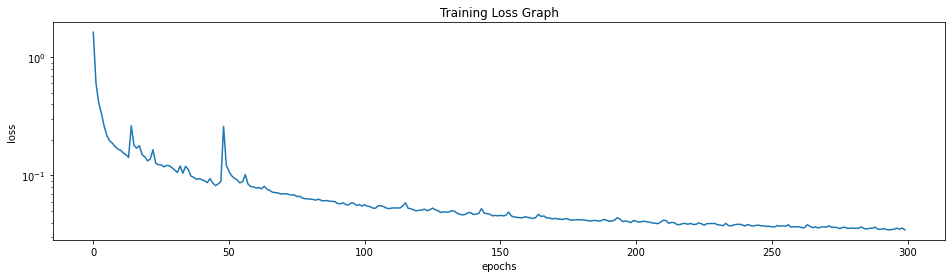

In [24]:
# loss curve
plt.figure(figsize=(16, 4))
plt.title("Training Loss Graph")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.yscale("log")
plt.plot(LOSS_HISTORY)
plt.show()

In [25]:
VALIDATION_DF_RAW = dataframe_from_csvs(VALIDATION_DATASET)
VALIDATION_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C78,C79,C80,C81,C82,C83,C84,C85,C86,attack
0,2021-07-10 00:00:01,-2.0395,0,11.78894,0.00058,16.32080,0.4010,12.903438,70,1,...,31.52100,0.716042,386.51172,356.64423,1,1034.712769,12.0,50,161,0
1,2021-07-10 00:00:02,-2.1750,0,11.78894,-0.00282,15.95459,0.4187,12.903438,70,1,...,31.51756,0.716042,411.33905,352.08698,1,1034.712769,12.0,50,155,0
2,2021-07-10 00:00:03,-2.5854,0,11.78131,-0.00398,14.79492,0.0691,12.903438,70,1,...,31.50269,0.716042,438.15259,347.63818,1,1034.712769,12.0,50,149,0
3,2021-07-10 00:00:04,-2.4722,0,11.78894,-0.00152,14.72626,0.3306,12.903438,70,1,...,31.47942,0.716042,465.95908,340.33203,1,1034.712769,12.0,50,148,0
4,2021-07-10 00:00:05,-2.2319,0,11.78131,0.00072,14.78729,0.2150,12.903438,70,1,...,31.47942,0.716042,452.05582,335.17798,1,1034.712769,12.0,50,148,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86395,2021-07-10 23:59:56,-2.8150,0,12.26196,0.00130,15.53497,-0.0507,12.669310,70,1,...,31.79814,0.716042,1193.48230,347.58386,1,1018.394040,12.0,50,7,0
86396,2021-07-10 23:59:57,-2.6272,0,12.26196,0.00109,15.53497,0.1829,12.669310,70,1,...,31.79738,0.716042,1179.76929,348.03607,1,1018.394040,12.0,50,7,0
86397,2021-07-10 23:59:58,-2.3564,0,12.26196,-0.00101,15.53497,0.2907,12.669310,70,1,...,31.78784,0.716042,1152.66187,348.81366,1,1018.394040,12.0,50,7,0
86398,2021-07-10 23:59:59,-2.1541,0,12.26196,-0.00166,15.53497,0.3280,12.669310,70,1,...,31.77029,0.716042,1130.65723,349.13916,1,1018.394040,12.0,50,7,0


In [26]:
VALIDATION_DF = normalize(VALIDATION_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET], TAG_MIN, TAG_MAX)

In [27]:
# validation을 위한 data loader 생성
HAI_DATASET_VALIDATION = HaiDataset(
    VALIDATION_DF_RAW[TIMESTAMP_FIELD], VALIDATION_DF, attacks=VALIDATION_DF_RAW[ATTACK_FIELD]
)
HAI_DATASET_VALIDATION[0]

  0%|          | 0/86311 [00:00<?, ?it/s]

# of valid windows: 86311


{'attack': 0.0,
 'ts': '2021-07-10 00:01:30',
 'given': tensor([[ 0.4743,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0208],
         [ 0.4495,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0204],
         [ 0.3742,  0.0000, -0.0423,  ...,  0.0000,  0.0000,  0.0199],
         ...,
         [ 0.4637,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0090],
         [ 0.4637,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0090],
         [ 0.4752,  0.0000, -0.0407,  ...,  0.0000,  0.0000,  0.0090]]),
 'answer': tensor([ 3.2394e-01,  0.0000e+00, -4.0688e-02,  5.5395e-01,  1.4765e-01,
          4.0518e-01,  1.1192e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
          4.0476e-01,  5.4933e-01,  4.3357e-01,  5.1551e-01,  3.9176e-01,
          2.2724e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  8.4392e-01,
          5.1435e-01,  0.0000e+00,  4.3408e-01,  2.6753e-01,  1.0705e-01,
          0.0000e+00,  4.3857e-01,  3.6767e-01,  0.0000e+00,  9.9556e-01,
          5.8638e-01,  2.9160e-01,  2.1829e-01,  

In [28]:
#inference 함수 정의
def inference(dataset, model, batch_size):
    dataloader = DataLoader(dataset, batch_size=batch_size)
    ts, dist, att = [], [], []
    with torch.no_grad():
        for batch in dataloader:
            given = batch["given"].cuda()
            answer = batch["answer"][:,DF_IDX].cuda()
            guess = model(given)
            ts.append(np.array(batch["ts"]))
            dist.append(((answer - guess)**2).cpu().numpy())
            try:
                att.append(np.array(batch["attack"]))
            except:
                att.append(np.zeros(batch_size))
            
    return (
        np.concatenate(ts),
        np.concatenate(dist),
        np.concatenate(att)
    )

In [29]:
# %%time
# validation data에 대한 inference
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT  = inference(HAI_DATASET_VALIDATION, MODEL, BATCH_SIZE)

In [30]:
# anomaly score median filter 정의
def moving_median(x, n= 10):
    a = []
    for i in range(n):
        a.append(np.concatenate([x[i:].copy(), np.zeros([i])]))
    median_ANOMALY_SCORE = np.stack(a)
    median_ANOMALY_SCORE.sort(0)
    # data leakage를 방지하기 위해 n만큼 shift해서 반환
    return np.concatenate([np.zeros([n]), median_ANOMALY_SCORE[n//2][:-n]])

In [31]:
# anomaly score 계산
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)
# data leakage 방지를 위해 이전 데이터에 대해서만 moving median 계산
# 최종 anomaly score (median_ANOMALY_SCORE)
FILTER_SIZE = 5
median_ANOMALY_SCORE = moving_median(ANOMALY_SCORE, n= FILTER_SIZE)

In [32]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
def check_graph(xs, att, piece=2, THRESHOLD=None, xs_comp = None):
    l = xs.shape[0]
    chunk = l // piece
    fig, axs = plt.subplots(piece, figsize=(20, 4 * piece))
    for i in range(piece):
        L = i * chunk
        R = min(L + chunk, l)
        xticks = range(L, R)
        axs[i].plot(xticks, xs[L:R])
        if xs_comp is not None:
            axs[i].plot(xticks, xs_comp[L:R], color = 'g')
        if len(xs[L:R]) > 0:
            peak = max(xs[L:R])
            axs[i].plot(xticks, att[L:R] * peak * 0.3)
            
        if THRESHOLD!=None:
            axs[i].axhline(y=THRESHOLD, color='r')
        axs[i].set_ylim(0,0.1)
        
        len_xick = len(str(len(xticks)))
        axs[i].xaxis.set_major_locator(MultipleLocator(10**(len_xick-1)))
        axs[i].xaxis.set_minor_locator(MultipleLocator(10**(len_xick-2)))
    plt.show()

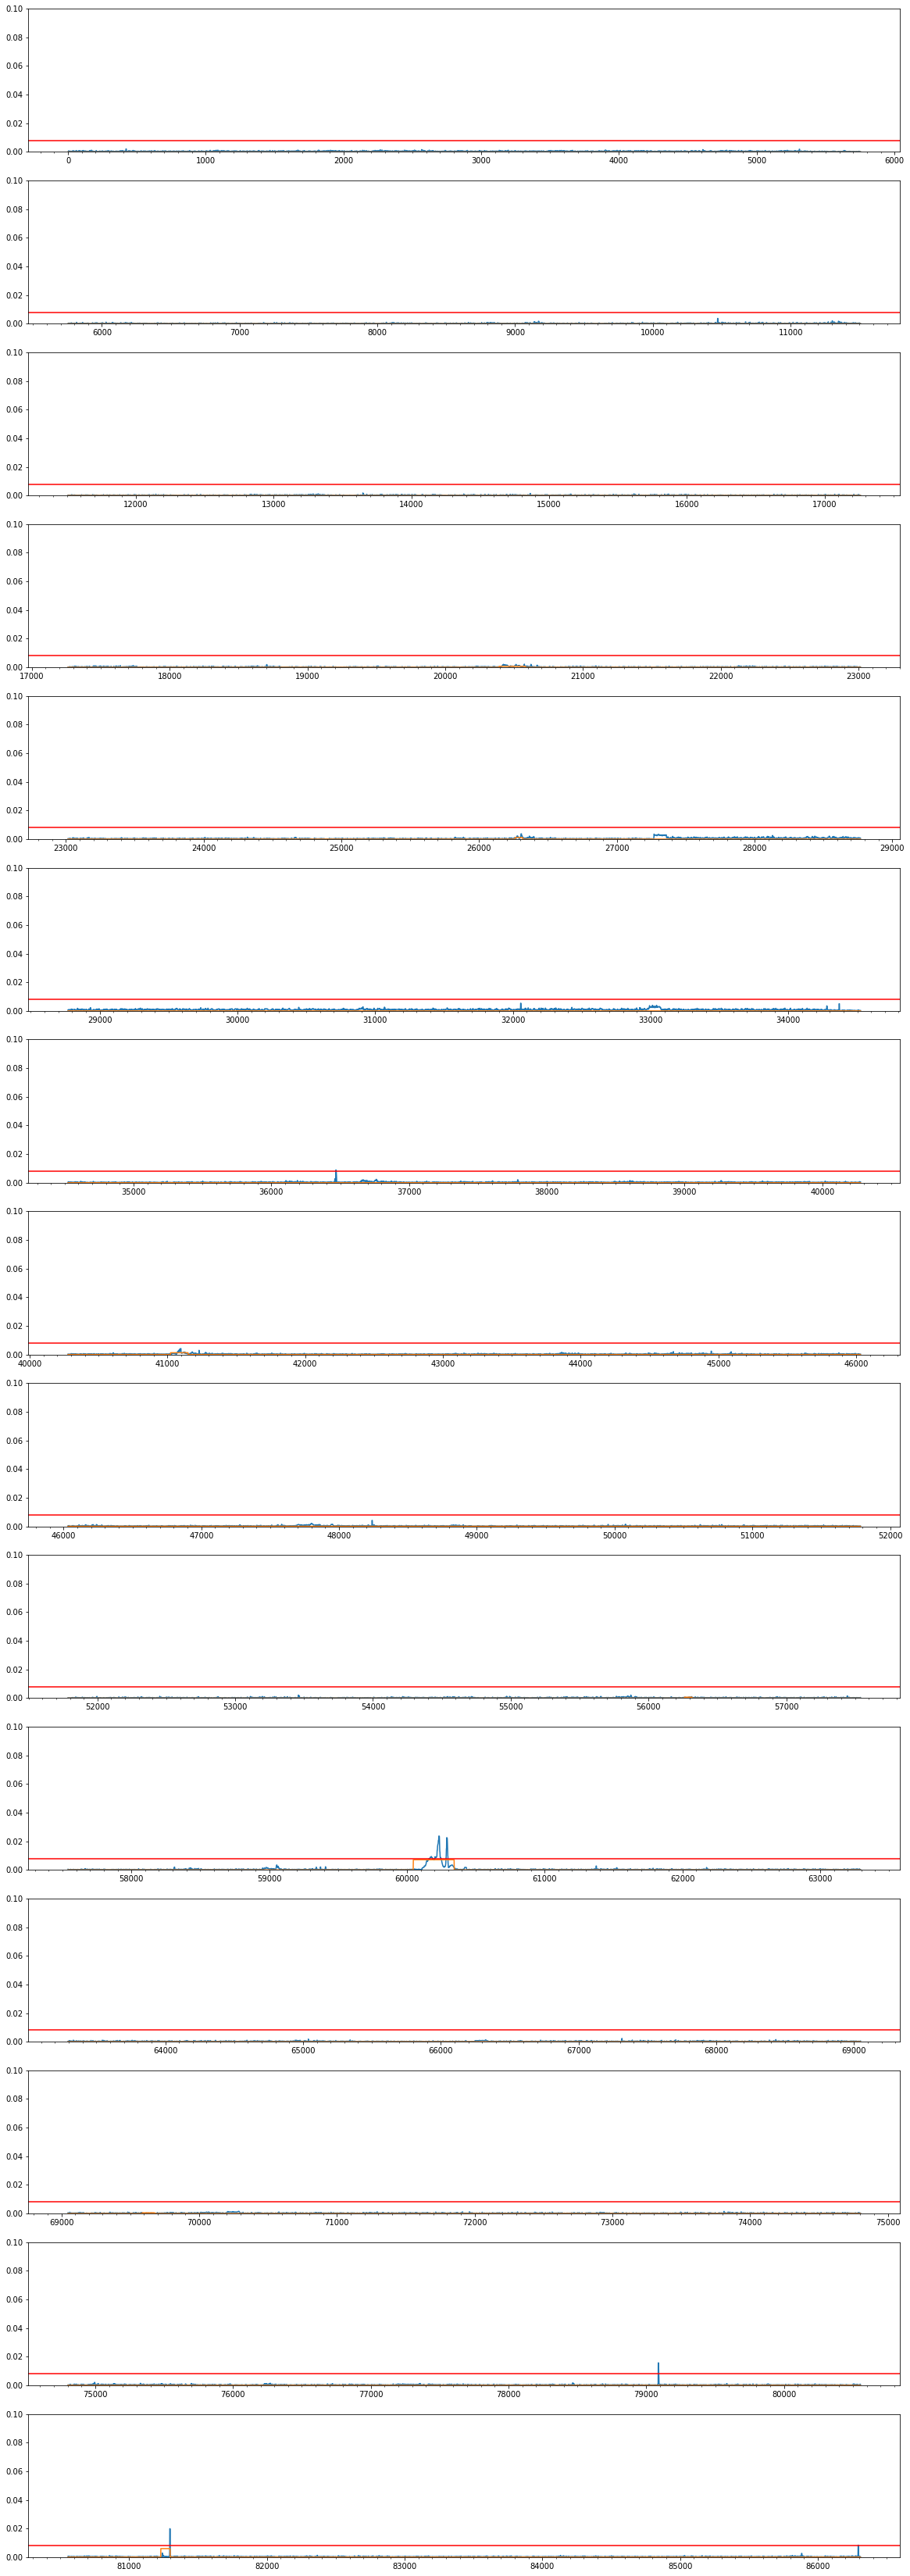

In [33]:
THRESHOLD = 0.008
check_graph(median_ANOMALY_SCORE, CHECK_ATT, piece=15, THRESHOLD=THRESHOLD)

In [34]:
# threshold와 anomaly score를 바탕으로 anomaly region 추론
def put_labels(distance, threshold):
    xs = np.zeros_like(distance)
    xs[distance > threshold] = 1
    return xs

In [35]:
LABELS = put_labels(median_ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.]), (86311,))

In [36]:
ATTACK_LABELS = put_labels(np.array(VALIDATION_DF_RAW[ATTACK_FIELD]), threshold=0.5)
ATTACK_LABELS, ATTACK_LABELS.shape

(array([0, 0, 0, ..., 0, 0, 0]), (86400,))

In [37]:
def fill_blank(check_ts, labels, total_ts):
    def ts_generator():
        for t in total_ts:
            yield dateutil.parser.parse(t)

    def label_generator():
        for t, label in zip(check_ts, labels):
            yield dateutil.parser.parse(t), label

    g_ts = ts_generator()
    g_label = label_generator()
    final_labels = []

    try:
        current = next(g_ts)
        ts_label, label = next(g_label)
        while True:
            if current > ts_label:
                ts_label, label = next(g_label)
                continue
            elif current < ts_label:
                final_labels.append(0)
                current = next(g_ts)
                continue
            final_labels.append(label)
            current = next(g_ts)
            ts_label, label = next(g_label)
    except StopIteration:
        return np.array(final_labels, dtype=np.int8)

In [38]:
# %%time
FINAL_LABELS = fill_blank(CHECK_TS, LABELS, np.array(VALIDATION_DF_RAW[TIMESTAMP_FIELD]))
FINAL_LABELS.shape

(86400,)

In [40]:
# validation data에 대한 TaPR 성능 측정
TaPR = etapr.evaluate_haicon(anomalies=ATTACK_LABELS, predictions=FINAL_LABELS)
print(f"F1: {TaPR['f1']:.3f} (TaP: {TaPR['TaP']:.3f}, TaR: {TaPR['TaR']:.3f})")
print(f"# of detected anomalies: {len(TaPR['Detected_Anomalies'])}")
print(f"Detected anomalies: {TaPR['Detected_Anomalies']}")

F1: 0.086 (TaP: 0.124, TaR: 0.066)
# of detected anomalies: 1
Detected anomalies: [<TaPR_pkg.DataManage.Range.Range object at 0x7fd0744acba8>]


In [41]:
TEST_DF_RAW = dataframe_from_csvs(TEST_DATASET)
TEST_DF_RAW

,timestamp,C01,C02,C03,C04,C05,C06,C07,C08,C09,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,2021-07-13 16:00:01,-2.1424,0,12.37640,-0.00275,8.02002,0.1524,12.58874,70,1,...,1.13464,29.09910,2.85153,227.61664,333.51416,1,981.36951,12.0,50,2100
1,2021-07-13 16:00:02,-2.0449,0,12.37640,-0.00087,8.02002,0.1281,12.58874,70,1,...,1.13312,29.14869,2.85153,231.58908,340.18738,1,981.36951,12.0,50,2165
2,2021-07-13 16:00:03,-2.1287,0,12.37640,-0.00260,8.02002,0.0148,12.58874,70,1,...,1.13388,29.18836,2.85153,229.60286,347.14990,1,981.36951,12.0,50,2209
3,2021-07-13 16:00:04,-2.1287,0,12.37640,-0.00282,8.02002,0.0148,12.58874,70,1,...,1.13541,29.24558,2.85153,229.60286,355.90277,1,981.36951,12.0,50,2233
4,2021-07-13 16:00:05,-2.5969,0,12.37640,0.00058,8.02002,-0.2225,12.58874,70,1,...,1.13541,29.24558,2.85153,222.65125,358.23566,1,981.36951,12.0,50,2290
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129595,2021-07-16 23:59:56,-1.8328,0,12.07123,0.00036,15.03143,0.8050,12.58870,70,1,...,0.92941,29.45263,2.40398,1056.03259,373.20966,1,1015.06964,12.0,50,22
129596,2021-07-16 23:59:57,-1.8328,0,12.07123,-0.00470,13.74206,0.8050,12.58870,70,1,...,0.92255,29.45758,2.40398,1026.05530,376.66376,1,1015.06964,12.0,50,22
129597,2021-07-16 23:59:58,-1.5833,0,12.07123,-0.00130,13.64288,0.9984,12.58870,70,1,...,0.92255,29.45034,2.40398,981.37659,377.76691,1,1015.06964,12.0,50,22
129598,2021-07-16 23:59:59,-1.4022,0,12.07123,0.00087,13.62762,1.0595,12.58870,70,1,...,0.92255,29.43088,2.40398,919.62439,378.99664,1,1015.06964,12.0,50,22


In [42]:
TEST_DF = normalize(TEST_DF_RAW[VALID_COLUMNS_IN_TRAIN_DATASET], TAG_MIN, TAG_MAX)#.ewm(span = 128).mean()
TEST_DF

,C01,C02,C03,C04,C05,C06,C07,C08,C09,C10,...,C77,C78,C79,C80,C81,C82,C83,C84,C85,C86
0,0.455432,0.0,0.079812,0.479046,0.077046,0.434169,0.711769,0.0,0.0,0.0,...,0.378726,0.095024,0.285153,0.068104,0.381526,0.0,0.393961,0.0,0.0,0.168791
1,0.473303,0.0,0.079812,0.501686,0.077046,0.429580,0.711769,0.0,0.0,0.0,...,0.377736,0.100035,0.285153,0.069354,0.406351,0.0,0.393961,0.0,0.0,0.173750
2,0.457943,0.0,0.079812,0.480853,0.077046,0.408184,0.711769,0.0,0.0,0.0,...,0.378231,0.104044,0.285153,0.068729,0.432253,0.0,0.393961,0.0,0.0,0.177108
3,0.457943,0.0,0.079812,0.478203,0.077046,0.408184,0.711769,0.0,0.0,0.0,...,0.379228,0.109826,0.285153,0.068729,0.464814,0.0,0.393961,0.0,0.0,0.178939
4,0.372125,0.0,0.079812,0.519147,0.077046,0.363372,0.711769,0.0,0.0,0.0,...,0.379228,0.109826,0.285153,0.066542,0.473493,0.0,0.393961,0.0,0.0,0.183289
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129595,0.512180,0.0,0.017216,0.516498,0.146735,0.557408,0.711717,0.0,0.0,0.0,...,0.245029,0.130748,0.240398,0.328704,0.529198,0.0,0.539339,0.0,0.0,0.010225
129596,0.512180,0.0,0.017216,0.455564,0.133920,0.557408,0.711717,0.0,0.0,0.0,...,0.240561,0.131248,0.240398,0.319274,0.542048,0.0,0.539339,0.0,0.0,0.010225
129597,0.557912,0.0,0.017216,0.496508,0.132934,0.593931,0.711717,0.0,0.0,0.0,...,0.240561,0.130516,0.240398,0.305219,0.546152,0.0,0.539339,0.0,0.0,0.010225
129598,0.591107,0.0,0.017216,0.522640,0.132782,0.605469,0.711717,0.0,0.0,0.0,...,0.240561,0.128550,0.240398,0.285793,0.550726,0.0,0.539339,0.0,0.0,0.010225


In [43]:
# test를 위한 data loader 생성
HAI_DATASET_TEST = HaiDataset(
    TEST_DF_RAW[TIMESTAMP_FIELD], TEST_DF, attacks=None
)
HAI_DATASET_TEST[0]

  0%|          | 0/274711 [00:00<?, ?it/s]

# of valid windows: 274533


{'ts': '2021-07-13 16:01:30',
 'given': tensor([[0.4554, 0.0000, 0.0798,  ..., 0.0000, 0.0000, 0.1688],
         [0.4733, 0.0000, 0.0798,  ..., 0.0000, 0.0000, 0.1738],
         [0.4579, 0.0000, 0.0798,  ..., 0.0000, 0.0000, 0.1771],
         ...,
         [0.3026, 0.0000, 0.0798,  ..., 0.0000, 0.0000, 0.0091],
         [0.3000, 0.0000, 0.0798,  ..., 0.0000, 0.0000, 0.0091],
         [0.3223, 0.0000, 0.0798,  ..., 0.0000, 0.0000, 0.0091]]),
 'answer': tensor([0.3600, 0.0000, 0.0798, 0.5000, 0.1030, 0.3983, 0.7118, 0.0000, 0.0000,
         0.0000, 0.3251, 0.4196, 0.4116, 0.3087, 0.5363, 0.2659, 0.0000, 0.0000,
         0.0000, 0.6997, 0.3091, 0.0000, 0.3025, 0.3172, 0.0066, 0.0000, 0.3042,
         0.3941, 0.0000, 0.8326, 0.4150, 0.2804, 0.4343, 0.0000, 0.2850, 0.0000,
         0.0577, 0.0000, 0.0000, 0.0186, 0.3399, 0.4616, 0.4488, 0.3947, 1.0000,
         1.0000, 0.9935, 1.0000, 0.0000, 0.0139, 0.7701, 0.0000, 0.6464, 0.0081,
         0.0000, 0.3064, 0.3181, 0.1386, 0.2675, 0.3532, 1.

In [44]:
# %%time
# test data에 대한 추론
MODEL.eval()
CHECK_TS, CHECK_DIST, CHECK_ATT = inference(HAI_DATASET_TEST, MODEL, BATCH_SIZE)

In [45]:
ANOMALY_SCORE = np.mean(CHECK_DIST, axis=1)

In [46]:
# test data의 anomaly score 계산
median_ANOMALY_SCORE = moving_median(ANOMALY_SCORE, n = FILTER_SIZE)

In [47]:
# anomaly region 추론
LABELS = put_labels(median_ANOMALY_SCORE, THRESHOLD)
LABELS, LABELS.shape

(array([0., 0., 0., ..., 0., 0., 0.]), (274533,))

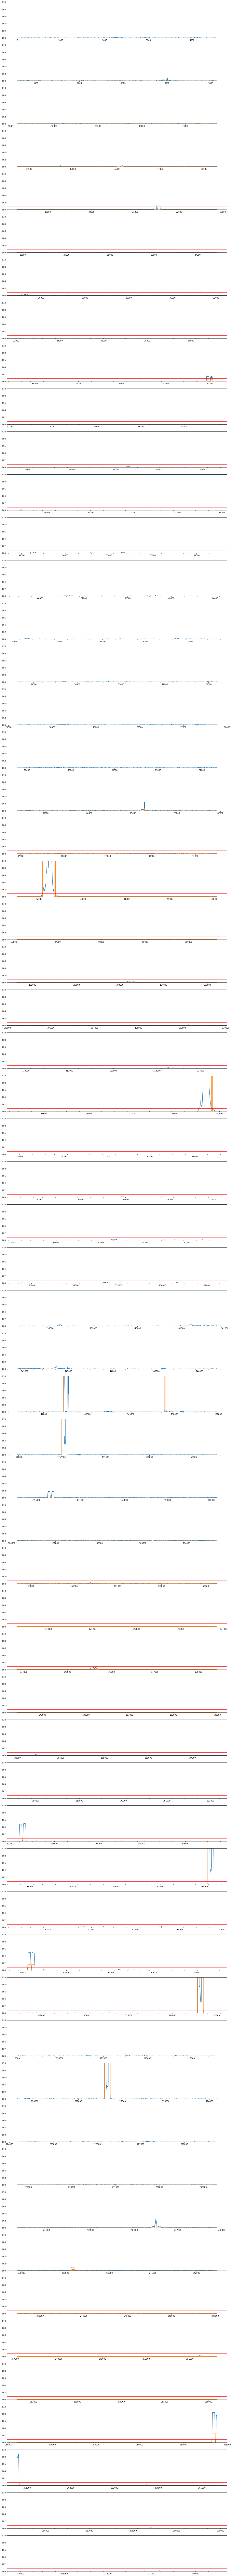

In [48]:
check_graph(median_ANOMALY_SCORE, LABELS, piece=60, THRESHOLD=THRESHOLD)

In [50]:
submission = pd.read_csv('./data/sample_submission.csv')
submission.index = submission['timestamp']
submission.loc[CHECK_TS,'attack'] = LABELS
submission

,timestamp,attack
timestamp,,
2021-07-13 16:00:01,2021-07-13 16:00:01,0.0
2021-07-13 16:00:02,2021-07-13 16:00:02,0.0
2021-07-13 16:00:03,2021-07-13 16:00:03,0.0
2021-07-13 16:00:04,2021-07-13 16:00:04,0.0
2021-07-13 16:00:05,2021-07-13 16:00:05,0.0
...,...,...
2021-07-16 23:59:56,2021-07-16 23:59:56,0.0
2021-07-16 23:59:57,2021-07-16 23:59:57,0.0
2021-07-16 23:59:58,2021-07-16 23:59:58,0.0


In [51]:
submission.to_csv('feature_1.csv', index=False)